# Constants and F(w,y)

In [1]:
import numpy as np
import mpmath as mp

mp.mp.dps = 30  # precision

def F_scalar(w, y):
    x_m  = 0.5 * (y + mp.sqrt(y**2 + 4))
    phi_m = 0.5 * (x_m - y)**2 - mp.log(x_m)

    exp_term   = mp.e ** ( mp.pi*w/4 + 0.5j*w*( mp.log(w/2) - 2*phi_m ) )
    gamma_term = mp.gamma(1 - 0.5j*w)
    hyper_term = mp.hyper([0.5j*w], [1], 0.5j*w*y**2)

    return exp_term * gamma_term * hyper_term


# ---- Physical constants for w = 8π M_L^z f ----

G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 299792458.0         # m/s
M_sun = 1.98847e30      # kg

def M_sec(M_lens_solar, z_lens=0.0):
    """
    Convert lens mass in solar masses (and lens redshift)
    into 'time' units (seconds) for geometric units G=c=1:
        M^z = (1+z_L) * G M / c^3
    """
    M_kg = M_lens_solar * M_sun
    return (1.0 + z_lens) * G * M_kg / c**3


# Calculating the unleansed waveform h(f)

In [4]:
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30, mass2=30,
                         spin1z=0, spin2z=0,
                         luminosity_distance=500,  # Mpc
                         coa_phase=0,
                         delta_f=1.0/8,
                         f_lower=20.0)

h_unlensed = hp  # unlensed waveform in freq space


# Extracting frequency array from hp.sample_frequencies

In [5]:
f_array = hp.sample_frequencies.numpy() if hasattr(hp.sample_frequencies, "numpy") else hp.sample_frequencies
f_array = np.array(f_array, dtype=float)  # ensure it's a NumPy array

# frequency array and lens mass to get w

In [6]:
M_lens = 100.0      # lens mass in solar masses
z_lens = 0.5
M_z_sec = M_sec(M_lens, z_lens)    # seconds

# Dimensionless frequency array w(f) = 8π M^z f
w_array = 8.0 * np.pi * M_z_sec * f_array   # same shape as f_array

# using w to get the amplification factor F(w), then Multiplying F(w(f)) and h(f)

In [12]:
y_source = 0.5

F_vals = np.zeros_like(w_array, dtype=complex)

for i, w in enumerate(w_array):
    # Avoid issues at exactly w=0 or extremely tiny w
    if w <= 0:
        F_vals[i] = 1.0 + 0.0j   # no lensing at DC or negative freqs
    else:
        F_mp = F_scalar(w, y_source)  # mpmath complex
        F_vals[i] = complex(F_mp)     # convert to standard Python complex



h_lensed = h_unlensed * F_vals

# plotting

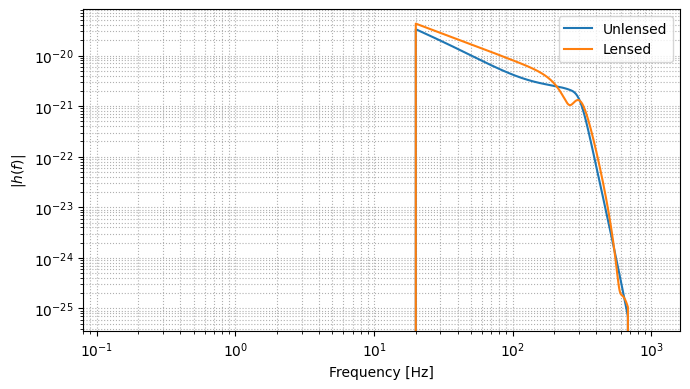

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.loglog(f_array, np.abs(h_unlensed), label="Unlensed")
plt.loglog(f_array, np.abs(h_lensed),   label="Lensed")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$|h(f)|$")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()
